<a href="https://colab.research.google.com/github/nickxir12/PatRec_Project_2024-2025/blob/main/MNIST_code/sample_complexity_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enter-data-dn-req/train.pt
/kaggle/input/enter-data-dn-req/test.pt
/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [15]:
#!pip install -r /kaggle/input/enter-data-dn-req/requirements.txt

In [2]:

import random
import time
import math
import argparse
from argparse import ArgumentParser
from collections import defaultdict
from itertools import islice
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision
from typing import List, Optional, Dict, Literal
from collections import deque
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
import struct
import gzip


In [3]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [4]:
def custom_collate_fn_2(batch):
    """Custom collate function to handle extra fields in the dataset."""
    images, labels, _, _ = zip(*batch)  # Ignore the indices and extra_fields for loss computation
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return images, labels

def compute_accuracy(model, dataset, device, N=None):
    """Utility to compute accuracy on a given dataset."""
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    correct = 0
    total = 0

    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn_2)

    for x, y in loader:  # Unpack index and extra_fields as well
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            predictions = outputs.argmax(dim=1)
        correct += (predictions == y).sum().item()
        total += y.size(0)
        if N is not None and total >= N:
            break
    return correct / total

def compute_loss(model, dataset, loss_function_name, device, N=None):
    """Utility to compute the average loss on a given dataset."""
    loss_fn = loss_function_dict[loss_function_name]()

    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn_2)
    total_loss = 0.0
    count = 0
    one_hots = torch.eye(10, device=device)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            if loss_function_name == 'CrossEntropy':
                loss = loss_fn(outputs, y)
            elif loss_function_name == 'MSE':
                loss = loss_fn(outputs, one_hots[y])
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        count += batch_size
        if N is not None and count >= N:
            break
    return total_loss / count


In [5]:
optimizer_dict = {
    'AdamW': torch.optim.AdamW,
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

activation_dict = {
    'ReLU': nn.ReLU,
    'Tanh': nn.Tanh,
    'Sigmoid': nn.Sigmoid,
    'GELU': nn.GELU
}

loss_function_dict = {
    'MSE': nn.MSELoss,
    'CrossEntropy': nn.CrossEntropyLoss
}

In [6]:

import os
results_dir = "/kaggle/working/results/pt"
os.makedirs(results_dir, exist_ok=True)
dataset_path = "/kaggle/input/enter-data-dn-req"
os.makedirs(results_dir, exist_ok=True)


In [7]:

import torch
import torchvision

from torch.utils.data import Dataset

#         Added extra fields to keep ema_gra and history
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, data, targets, transform=None):
        """
        Custom dataset to simulate MyMNIST behavior with extra fields.
        Args:
            data: Tensor of shape [N, 28, 28].
            targets: Tensor of shape [N].
            transform: Transformations to apply to the images.
        """
        self.data = data.to(torch.float32)
        self.targets = targets
        self.transform = transform

        # Initialize extra fields
        self.extra_fields = [{
            "ema_grad": 0.0,         # EMA of gradient
             "num_updates":0,
            "deviation_metric": 0.0, # Deviation metric
            #"variance_metric": 0.0   # Variance metric
        } for _ in range(len(self.data))]

    def __getitem__(self, index):
        """
        Returns a single data sample and its associated extra fields.
        """
        img, target = self.data[index], self.targets[index]
        if self.transform:
            img = self.transform(img)
        extra_field = self.extra_fields[index]
        return img, target, index, extra_field

    def update_fields(self, indices, grad_stats,ema_alpha=0.9):
        """
        Update the extra fields for specified dataset indices.
        """

        for idx, grad  in zip(indices, grad_stats):
          # Update EMA
          sample_field = self.extra_fields[idx]
    

          current_ema = sample_field["ema_grad"]
          updated_ema = ema_alpha * current_ema + (1 - ema_alpha) * grad
          sample_field["ema_grad"] = updated_ema

          deviation = abs(grad - updated_ema)
            
          num_updates = sample_field["num_updates"] + 1  # Increment the update count
          current_avg_deviation = sample_field["deviation_metric"]
          new_avg_deviation = ((current_avg_deviation * (num_updates - 1)) + deviation) / num_updates
        
          # Update the deviation metric and number of updates
          sample_field["deviation_metric"] = new_avg_deviation
          sample_field["num_updates"] = num_updates
            
          #sample_field["deviation_metric"] += deviation
          # Optionally update variance-like metric
          # Variance estimate (for higher sensitivity to fast changes)
          #sample_field["variance_metric"] += (deviation ** 2)


In [8]:
def custom_collate_fn(batch):
    images, labels, indices, extra_fields = zip(*batch)
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return images, labels, indices, extra_fields

In [9]:
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.autograd import grad

def main(args,train_dataset,train_loader,test):
    log_freq = math.ceil(args.optimization_steps / 150)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32

    one_hots = torch.eye(10, 10).to(device)

    torch.set_default_dtype(dtype)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    random.seed(args.seed)
    np.random.seed(args.seed)

    #                                   Create model
    #   -------------------------------------------------------------------------------   #
    activation_fn = activation_dict[args.activation]
    layers = [nn.Flatten()]
    for i in range(args.depth):
        if i == 0:
            layers.append(nn.Linear(784, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            layers.append(nn.Linear(args.width, 10))
        else:
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)
    with torch.no_grad():
        for p in mlp.parameters():
            p.data = args.initialization_scale * p.data
    nparams = sum([p.numel() for p in mlp.parameters() if p.requires_grad])
    print(f'Number of parameters: {nparams}')

    # create optimizer
    assert args.optimizer in optimizer_dict, f"Unsupported optimizer choice: {args.optimizer}"
    optimizer = optimizer_dict[args.optimizer](mlp.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # define loss function
    assert args.loss_function in loss_function_dict
    loss_fn = loss_function_dict[args.loss_function]()

    # Initialize EMA and metric history for each sample
    gradient_ema = [0.0 for _ in range(len(train_dataset))]
    ema_alpha = 0.9  # Exponential moving average factor


    #                           Start Training below
    #   -------------------------------------------------------------------------------   #
    steps, log_steps, train_losses, train_accuracies, test_losses, test_accuracies = 0, [], [], [], [], []
    one_hots = torch.eye(10, 10).to(device)
    os.makedirs(results_dir, exist_ok=True)

    with tqdm(total=args.optimization_steps, dynamic_ncols=True) as pbar:

        reached_early_stop = False  # Flag to indicate early stopping
        steps_to_reach_val_acc = None  # Variable to store steps for 0.95 validation accuracy

        stable_threshold = 100  # Number of steps the validation accuracy must remain > 0.85
        stable_steps = 0  # Counter for steps validation accuracy remains above 0.85

        for batch in islice(cycle(train_loader), args.optimization_steps):
            x, labels, indices, extra_fields = batch
            do_log = (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0
            if do_log:
                train_losses.append(compute_loss(mlp, train_dataset, args.loss_function, device, N=len(train_dataset)))
                train_accuracies.append(compute_accuracy(mlp, train_dataset, device, N=len(train_dataset)))
                test_losses.append(compute_loss(mlp, test, args.loss_function, device, N=len(test)))
                test_accuracies.append(compute_accuracy(mlp, test, device, N=len(test)))
                log_steps.append(steps)
                pbar.set_description(
                "Loss: {0:1.1e}|{1:1.1e}. Acc: {2:2.1f}%|{3:2.1f}%".format(
                    train_losses[-1],
                    test_losses[-1],
                    train_accuracies[-1] * 100,
                    test_accuracies[-1] * 100,
                )
            )

            x, labels = x.to(device), labels.to(device)
            y = mlp(x.to(device))
            if args.loss_function == 'CrossEntropy':
                # Use integer labels for CrossEntropyLoss
                loss = loss_fn(y, labels)
            elif args.loss_function == 'MSE':
                loss = loss_fn(y, one_hots[labels])

            optimizer.zero_grad()
            loss.backward(create_graph=True)

            # -----------------------------------------------------------------
            #   Gradient Stats: Capture grads for each sample
            # -----------------------------------------------------------------

            # Identify the last two Linear layers dynamically
            layers = [layer for layer in reversed(mlp) if isinstance(layer, nn.Linear)]
            if len(layers) < 2:
                raise ValueError("The network does not have at least two Linear layers.")

            last_layer = layers[0].weight 
            second_last_layer = layers[1].weight 

            # Compute per sample gradients for two layers
            per_sample_grad_last = grad(loss, last_layer, create_graph=False, retain_graph=True)[0]  # Grad for last layer
            per_sample_grad_second_last = grad(loss, second_last_layer, create_graph=False, retain_graph=True)[0]  # Grad for second-to-last layer

            # Shuffle the second-to-last layer gradients
            torch.manual_seed(42)
            shuffled_second_last = per_sample_grad_second_last.flatten()  # Flatten the tensor for shuffling
            shuffled_indices = torch.randperm(shuffled_second_last.size(0))  # Generate a random permutation of indices
            shuffled_second_last = shuffled_second_last[shuffled_indices]  # Apply the shuffle
            
            # Select the first 10 elements after shuffling
            shuffled_second_last_subset = shuffled_second_last[:10]
            # Concatenate the last layer gradients with the shuffled subset of the second-to-last layer gradients
            shuffled_second_last_subset = shuffled_second_last_subset.unsqueeze(1)  # Add an extra dimension
            
            # Check dimensions of tensors
            assert per_sample_grad_last.dim() == shuffled_second_last_subset.dim(), \
                f"Dimension mismatch: per_sample_grad_last has dim {per_sample_grad_last.dim()}, " \
                f"shuffled_second_last_subset has dim {shuffled_second_last_subset.dim()}"
            
          
            # Concatenate the last layer gradients with the shuffled subset of the second-to-last layer gradients

            per_sample_grads = torch.cat((per_sample_grad_last, shuffled_second_last_subset), dim = 1)

            batch_mean_grads = per_sample_grads.view(per_sample_grads.size(0), -1).mean(dim=0)  # Shape: [batch_size]
            
            # Update fields for the parent dataset if train_dataset is a Subset

            train_dataset.dataset.update_fields(indices, batch_mean_grads, ema_alpha)


            optimizer.step()

            test_acc = test_accuracies[-1] if len(test_accuracies) > 0 else 0
            # Check for early stopping conditions
            if test_acc >= 0.95 and steps_to_reach_val_acc is None:
                steps_to_reach_val_acc = steps  # Record the first step reaching 0.95 validation accuracy

            if test_acc > 0.9:
                stable_steps += 1
            else:
                stable_steps = 0  # Reset counter if accuracy drops below 0.9

            if stable_steps >= stable_threshold and test_acc >= 0.95:
                reached_early_stop = True
                print(f"Validation accuracy of 0.95 reached and remained > 0.9 for {stable_threshold} steps at step {steps}")


            steps += 1
            pbar.update(1)

    # Save results
    results_filename = os.path.join(results_dir, f"mnist_{args.label}.pt")
    os.makedirs(results_dir, exist_ok=True)
    torch.save({
        'its': log_steps,
        'train_acc': train_accuracies,
        'train_loss': train_losses,
        'val_acc': test_accuracies,
        'val_loss': test_losses,
        'steps_to_reach': steps_to_reach_val_acc,
    }, results_filename)

    return train_dataset, steps_to_reach_val_acc


In [10]:

import sys
from argparse import ArgumentParser

# Remove the extra arguments passed by the Jupyter Notebook kernel
sys.argv = ['']


In [11]:

#     Same as used in paper of Grokfast
args = argparse.Namespace(
    train_points=10000,
    optimization_steps=1000,
    batch_size=200,
    loss_function="CrossEntropy",#changed
    optimizer="AdamW",
    weight_decay=0.01,
    lr=1e-3,
    initialization_scale=8.0,
    download_directory=".",
    depth=3,#changed
    width=200,#changed
    activation="ReLU",
    seed=42,
    label="experiment_initial_2l"
)



In [12]:

    #                                 Load dataset
    #   -------------------------------------------------------------------------------   #


    train_data = torch.load(f"{dataset_path}/train.pt",weights_only=True)
    test_data = torch.load(f"{dataset_path}/test.pt",weights_only=True)

    transform = None

    train_images, train_labels = train_data
    test_images, test_labels = test_data


    # Create MyMNIST datasets
    train_dataset = MyMNIST(train_images, train_labels, transform=transform)
    test_dataset = MyMNIST(test_images, test_labels, transform=transform)


    # # Create indices & stratify
    train_indices = list(range(len(train_dataset)))
    train_labels = [train_dataset.targets[i].item() for i in train_indices]

    # Use train_test_split with stratification to randomly select a specified number of samples (args.train_points)
    stratified_indices, _ = train_test_split(
        train_indices,
        train_size=args.train_points,
        stratify=train_labels,
        random_state=args.seed
    )

    train_dataset = torch.utils.data.Subset(train_dataset, stratified_indices)
    
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,collate_fn=custom_collate_fn)


    # We'll just use the full test dataset
    test = test_dataset



In [13]:
print(len(train_dataset))

10000


In [14]:
import time

# Start the timer
start_time = time.time()

# Call your training function
upd_train_dataset, steps_to_reach_val_acc = main(args, train_dataset, train_loader, test)

# End the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert to minutes and seconds (optional)
minutes, seconds = divmod(elapsed_time, 60)

print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")


Number of parameters: 199210


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1201.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training completed in 1 minutes and 34 seconds.


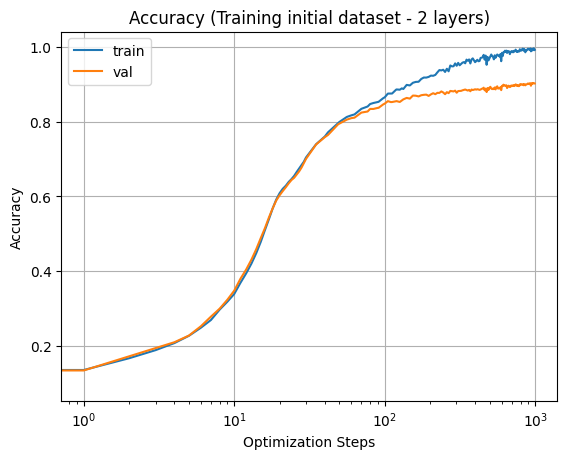

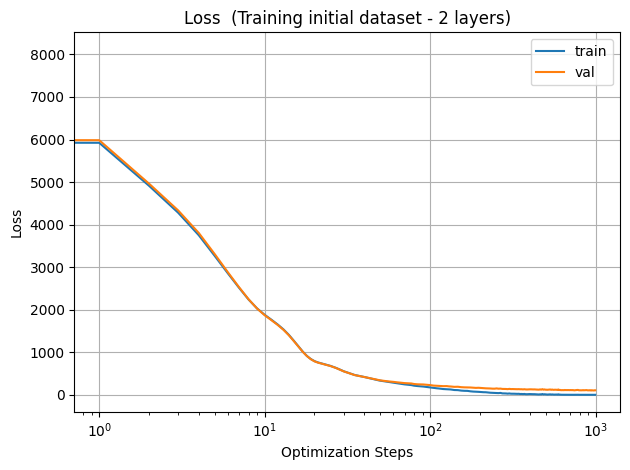

In [15]:
results_pt_dir = "/kaggle/working/results/pt"

file = "mnist_experiment_initial_2l.pt"

results_pt_dir = os.path.join(results_pt_dir, file)

results = torch.load(results_pt_dir, weights_only=True)

# Extract data from results
its = results["its"]  # Optimization steps
train_acc = results["train_acc"]  # Training accuracy
val_acc = results["val_acc"]  # Validation accuracy
train_loss = results["train_loss"]  # Training loss
val_loss = results["val_loss"]  # Validation loss

# Find the exact value at optimization step 1000
step_index = its.index(1000) if 1000 in its else -1

# Plot Accuracy
plt.figure()
plt.plot(its, train_acc, label="train")
plt.plot(its, val_acc, label="val")
plt.legend()
plt.title(f"Accuracy (Training initial dataset - 2 layers)")
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.xscale("log", base=10)
plt.grid()
#plt.savefig(f"{results_dir}/acc/acc_{args_label}_lambda_{lamb}_alpha_{alpha}.png", dpi=150)
#plt.close()

# Plot Loss
plt.figure()
plt.plot(its, train_loss, label="train")
plt.plot(its, val_loss, label="val")
plt.legend()
plt.title(f"Loss  (Training initial dataset - 2 layers)")
plt.xlabel("Optimization Steps")
plt.ylabel("Loss")
plt.xscale("log", base=10)
plt.grid()
#plt.savefig(f"{results_dir}/loss/loss_{args_label}_lambda_{lamb}_alpha_{alpha}.png", dpi=150)
#plt.close()
plt.tight_layout()
plt.show()


In [16]:
parent_dataset = upd_train_dataset.dataset  # Parent dataset
subset_indices = upd_train_dataset.indices  # Indices of the subset

# Accessing subset data from parent dataset
for idx, subset_idx in enumerate(subset_indices[:10]): 
    print(f"Sample {idx} (Subset Index {subset_idx}): {upd_train_dataset.dataset.extra_fields[subset_idx]}")


Sample 0 (Subset Index 25171): {'ema_grad': tensor(1.7924e-08, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.1210e-07, device='cuda:0')}
Sample 1 (Subset Index 25726): {'ema_grad': tensor(6.3211e-09, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.6203e-08, device='cuda:0')}
Sample 2 (Subset Index 14385): {'ema_grad': tensor(9.7445e-09, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(4.1906e-08, device='cuda:0')}
Sample 3 (Subset Index 50759): {'ema_grad': tensor(1.1658e-08, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(6.3902e-08, device='cuda:0')}
Sample 4 (Subset Index 35230): {'ema_grad': tensor(9.9384e-09, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(6.8282e-08, device='cuda:0')}
Sample 5 (Subset Index 57626): {'ema_grad': tensor(-2.0426e-09, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.3536e-08, device='cuda:0')}
Sample 6 (Subset Index 38618): {'ema_grad': tensor(5.6923

In [17]:
import random
from torch.utils.data import Subset

def classify_samples_r(subset, retain_top_pct=60, random_retain_pct=5, seed=None):

    if seed is not None:
        random.seed(seed)

    # Access the parent dataset and subset indices
    parent_dataset = subset.dataset
    subset_indices = subset.indices
    
    # Collect indices and deviation values within the subset
    subset_samples = [
    (idx, parent_dataset.extra_fields[idx]["deviation_metric"]) for idx in subset_indices
    ]
    
    # Sort by deviation in descending order
    sorted_samples = sorted(subset_samples, key=lambda x: x[1], reverse=True)
    #sorted_samples = sorted(subset_samples, key=lambda x: x[1])
    
    # Calculate the number of samples to retain
    total_samples = len(sorted_samples)
    top_k_count = int(total_samples * (retain_top_pct / 100))
    random_count = int(total_samples * (random_retain_pct / 100))
    
    # Select top-k samples
    top_k_indices = [idx for idx, _ in sorted_samples[:top_k_count]]
    
    # Select the remaining samples (excluding top-k)
    remaining_samples = sorted_samples[top_k_count:]
    remaining_indices = [idx for idx, _ in remaining_samples]
    
    # Randomly select a percentage of the remaining samples
    random_selected_indices = random.sample(remaining_indices, min(random_count, len(remaining_indices)))
    
    # Combine selected indices
    selected_indices = top_k_indices + random_selected_indices
    
    # Return the new dataset as a subset
    new_dataset = Subset(parent_dataset, selected_indices)
    return new_dataset
    


In [18]:
def classify_samples(subset, top_pct=20, bottom_pct=20, seed=None):
    """
    Select the top and bottom percentage of samples based on deviation_metric.
    
    Parameters:
    - subset: A Subset of the original dataset.
    - top_pct: Percentage of samples with the highest deviation to retain.
    - bottom_pct: Percentage of samples with the lowest deviation to retain.
    - seed: Random seed for reproducibility (optional).
    
    Returns:
    - new_dataset: Subset of the original dataset based on the selected samples.
    """
    if seed is not None:
        random.seed(seed)

    # Access the parent dataset and subset indices
    parent_dataset = subset.dataset
    subset_indices = subset.indices

    # Collect indices and deviation values within the subset
    subset_samples = [
        (idx, parent_dataset.extra_fields[idx]["deviation_metric"]) for idx in subset_indices
    ]

    # Sort by deviation in ascending order (lowest deviations first)
    sorted_samples = sorted(subset_samples, key=lambda x: x[1])
    
    # Calculate the number of samples to retain
    total_samples = len(sorted_samples)
    top_k_count = int(total_samples * (top_pct / 100))
    bottom_k_count = int(total_samples * (bottom_pct / 100))
    
    # Select the bottom-k samples
    bottom_k_indices = [idx for idx, _ in sorted_samples[:bottom_k_count]]
    
    # Select the top-k samples
    top_k_indices = [idx for idx, _ in sorted_samples[-top_k_count:]]
    
    # Combine selected indices
    selected_indices = bottom_k_indices + top_k_indices

    # Return the new dataset as a subset
    new_dataset = Subset(parent_dataset, selected_indices)
    return new_dataset


In [24]:
new_train_dataset = classify_samples(upd_train_dataset, top_pct=70, bottom_pct=10, seed=42)

In [25]:
new_train_dataset = classify_samples_r(upd_train_dataset, retain_top_pct=20, random_retain_pct=20, seed=42)

In [26]:
print(f"Dataset size: {len(new_train_dataset)}")


Dataset size: 4000


In [27]:
print(f"Subset indices: {new_train_dataset.indices[:10]} ... (total {len(new_train_dataset.indices)})")


Subset indices: [56520, 21457, 59834, 37239, 5091, 30973, 27300, 59941, 7264, 39644] ... (total 4000)


In [28]:
new_train_loader = DataLoader(new_train_dataset, batch_size=args.batch_size, shuffle=True,collate_fn=custom_collate_fn)

In [29]:
# Debug: Check the first few samples in the new dataset
for idx in new_train_dataset.indices[:10]:  # Access the first 10 indices of the subset
    print(f"Sample {idx}: {upd_train_dataset.dataset.extra_fields[idx]}")


Sample 56520: {'ema_grad': tensor(3.3586e-07, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(2.0461e-06, device='cuda:0')}
Sample 21457: {'ema_grad': tensor(2.8906e-07, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.7925e-06, device='cuda:0')}
Sample 59834: {'ema_grad': tensor(-1.9864e-07, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.2839e-06, device='cuda:0')}
Sample 37239: {'ema_grad': tensor(2.0625e-07, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.2805e-06, device='cuda:0')}
Sample 5091: {'ema_grad': tensor(1.6166e-07, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.0259e-06, device='cuda:0')}
Sample 30973: {'ema_grad': tensor(-1.6490e-07, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.0244e-06, device='cuda:0')}
Sample 27300: {'ema_grad': tensor(1.7151e-07, device='cuda:0'), 'num_updates': 20, 'deviation_metric': tensor(1.0215e-06, device='cuda:0')}
Sample 59941: {'ema

In [160]:
# def reset_metrics(dataset):
#     """
#     Reset all metrics in the dataset's `extra_fields` to their initial values.
#     """
#     for field in dataset.extra_fields:
#         field["ema_grad"] = 0.0
#         field["num_updates"] = 0
#         field["deviation_metric"] = 0.0

In [ ]:
# # Reset metrics in the parent dataset
# reset_metrics(new_train_dataset.dataset)

# # Debug: Check the first few samples in the dataset after resetting
# for idx in train_dataset.indices[:10]:  # Access the first 10 indices of the subset
#     print(f"Sample {idx}: {train_dataset.dataset.extra_fields[idx]}")

In [30]:
test_dataset = MyMNIST(test_images, test_labels, transform=transform)
test=test_dataset
args = argparse.Namespace(
    train_points=10000,
    optimization_steps=1000,
    batch_size=200,
    loss_function="CrossEntropy",#changed
    optimizer="AdamW",
    weight_decay=0.01,
    lr=1e-3,
    initialization_scale=8.0,
    download_directory=".",
    depth=3,#changed
    width=200,#changed
    activation="ReLU",
    seed=42,
    label="experiment_with_faster_2layers"
)
upd_train_dataset_2, steps_to_reach_val_acc= main(args,new_train_dataset,new_train_loader,test)

Number of parameters: 199210


  0%|          | 0/1000 [00:00<?, ?it/s]

Plots saved successfully.


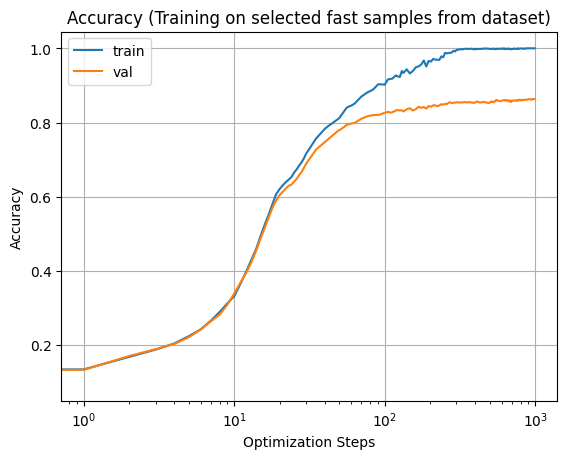

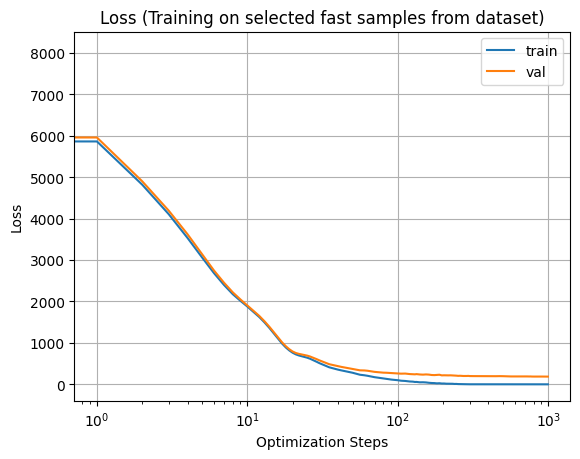

In [31]:

results_pt_dir = "/kaggle/working/results/pt"

file="mnist_experiment_with_faster_2layers.pt"

results_pt_dir = os.path.join(results_pt_dir, file)

results = torch.load(results_pt_dir,weights_only=True)


# Extract data from results
its = results["its"]  # Optimization steps
train_acc = results["train_acc"]  # Training accuracy
val_acc = results["val_acc"]  # Validation accuracy
train_loss = results["train_loss"]  # Training loss
val_loss = results["val_loss"]  # Validation loss

# Plot Accuracy
plt.figure()
plt.plot(its, train_acc, label="train")
plt.plot(its, val_acc, label="val")
plt.legend()
plt.title(f"Accuracy (Training on selected fast samples from dataset)")
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.xscale("log", base=10)
plt.grid()
#plt.savefig(f"{results_dir}/acc/acc_{args_label}_lambda_{lamb}_alpha_{alpha}.png", dpi=150)
#plt.close()

# Plot Loss
plt.figure()
plt.plot(its, train_loss, label="train")
plt.plot(its, val_loss, label="val")
plt.legend()
plt.title(f"Loss (Training on selected fast samples from dataset)")
plt.xlabel("Optimization Steps")
plt.ylabel("Loss")
plt.xscale("log", base=10)
plt.grid()
#plt.savefig(f"{results_dir}/loss/loss_{args_label}_lambda_{lamb}_alpha_{alpha}.png", dpi=150)
#plt.close()

print("Plots saved successfully.")